## Classical Diffusion Model ##

This architecture follows the quantum diffusion model structure, training the same number of parameters, using the same number of layers, and following the same complexity. It is used as a baseline for comparison between the classical and quantum models for the same tasks.

In [ ]:
from utils.statistics import calculate_statistics, calculate_fid
from utils.decoding import decode, flip


First, a classical model without the quantum layer but with the same shapes and encodings. There are also some versions of the model with validation and with self-attention at the end.

In [8]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.classical_noising import *

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg

C:\Users\realc\OneDrive\Documents\GSOC


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


160.3791599407243


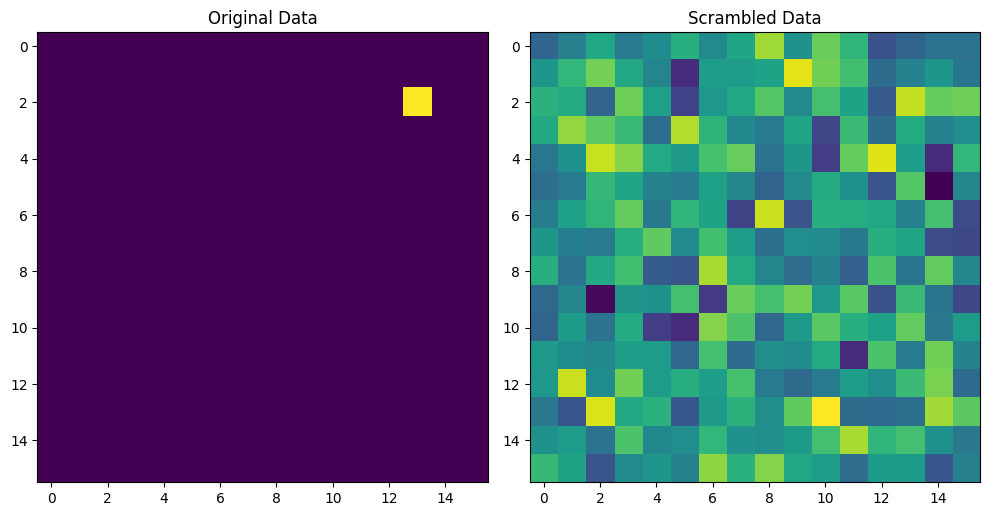

In [12]:
filename = "data/QG1_normalized_16x16_100k"
data_X = np.array(h5py.File(filename, "r")['X'])

# Function to visualize the original and scrambled states
def visualize_scrambled_data(original_data, scrambled_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(scrambled_data[sample_index], cmap='viridis')
    axes[1].set_title("Scrambled Data")
    
    plt.tight_layout()
    plt.show()

# Helper function to calculate FID while plotting
def compute_fid(model, scrambled_states, data_X):
    denoised_states = model(scrambled_states).view(num_samples, 8, 8, 4).detach().numpy()
    decoded_data = decode(denoised_states)
    mu1, sigma1 = calculate_statistics(data_X)
    mu2, sigma2 = calculate_statistics(decoded_data)
    return calculate_fid(mu1, sigma1, mu2, sigma2)

num_samples = 10000
seed = 42

scrambled_states = scramble_vectors(data_X[:num_samples], seed=42)
mu1, sigma1 = calculate_statistics(data_X)
mu2, sigma2 = calculate_statistics(scrambled_states)
initial_fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(initial_fid)

visualize_scrambled_data(data_X, scrambled_states, sample_index=0)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32).view(num_samples, -1)
encoded_data = torch.tensor(data_X[:num_samples], dtype=torch.float32).view(num_samples, -1)

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=seed, shuffle=True
)

Epoch [1/50], Train Loss: 0.00829, Val Loss: 0.00682
Epoch [2/50], Train Loss: 0.00757, Val Loss: 0.00642
Epoch [3/50], Train Loss: 0.00703, Val Loss: 0.00608
Epoch [4/50], Train Loss: 0.00661, Val Loss: 0.00579
Epoch [5/50], Train Loss: 0.00626, Val Loss: 0.00553
Epoch [6/50], Train Loss: 0.00598, Val Loss: 0.00530
Epoch [7/50], Train Loss: 0.00572, Val Loss: 0.00508
Epoch [8/50], Train Loss: 0.00550, Val Loss: 0.00488
Epoch [9/50], Train Loss: 0.00531, Val Loss: 0.00469
Epoch [10/50], Train Loss: 0.00514, Val Loss: 0.00451
Epoch [11/50], Train Loss: 0.00500, Val Loss: 0.00435
Epoch [12/50], Train Loss: 0.00489, Val Loss: 0.00423
Epoch [13/50], Train Loss: 0.00478, Val Loss: 0.00414
Epoch [14/50], Train Loss: 0.00468, Val Loss: 0.00407
Epoch [15/50], Train Loss: 0.00460, Val Loss: 0.00401
Epoch [16/50], Train Loss: 0.00452, Val Loss: 0.00397
Epoch [17/50], Train Loss: 0.00446, Val Loss: 0.00394
Epoch [18/50], Train Loss: 0.00440, Val Loss: 0.00391
Epoch [19/50], Train Loss: 0.00435, V

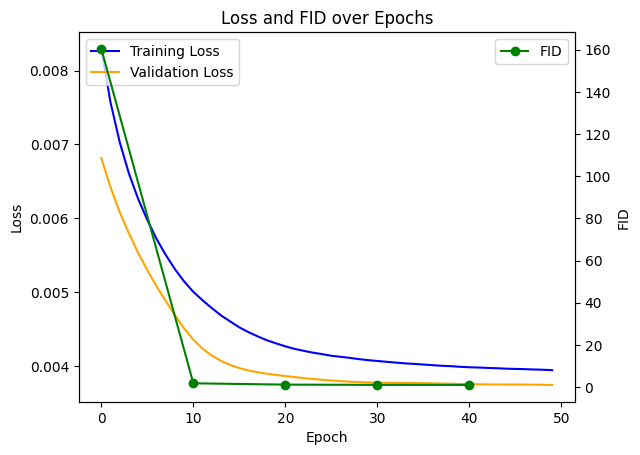

In [16]:
class ClassicalDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(ClassicalDiffusionModel, self).__init__()
        self.n_layers = n_layers
        
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)])
        
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < self.n_layers:
                x = torch.relu(x)
                x = self.dropout(x)
        return x

input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
n_layers = 8

model = ClassicalDiffusionModel(input_dim, hidden_dim, output_dim, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_loss_values = []
val_loss_values = []
fid_values = [initial_fid]

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states)
    train_loss = criterion(outputs, train_encoded_data)
    train_loss.backward()
    optimizer.step()
    train_loss_values.append(train_loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states)
        val_loss = criterion(val_outputs, val_encoded_data)
        val_loss_values.append(val_loss.item())
    
    if epoch % 10 == 0:
        fid = compute_fid(model, scrambled_states, data_X)
        fid_values.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.5f}, Val Loss: {val_loss.item():.5f}')

epochs = list(range(num_epochs))
fid_epochs = list(range(0, num_epochs, 10))

fig, ax1 = plt.subplots()

ax1.plot(epochs, train_loss_values, label='Training Loss', color='blue')
ax1.plot(epochs, val_loss_values, label='Validation Loss', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')
ax1.set_title('Loss and FID over Epochs')

# Add second y-axis for FID
fid_values.pop()
ax2 = ax1.twinx()
ax2.plot(fid_epochs, fid_values, label='FID', color='green', marker='o')
ax2.set_ylabel('FID')
ax2.legend(loc='upper right')

plt.show()

In [17]:
denoised_states = model(scrambled_states).view(num_samples, 8, 8, 4).detach().numpy()

decoded_data = decode(denoised_states)
# decoded_data = flip(decoded_data)
print(decoded_data.shape)

mu1, sigma1 = calculate_statistics(data_X)
mu2, sigma2 = calculate_statistics(decoded_data)

fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID score: {fid}")

(10000, 16, 16)
FID score: 0.9814036109461721


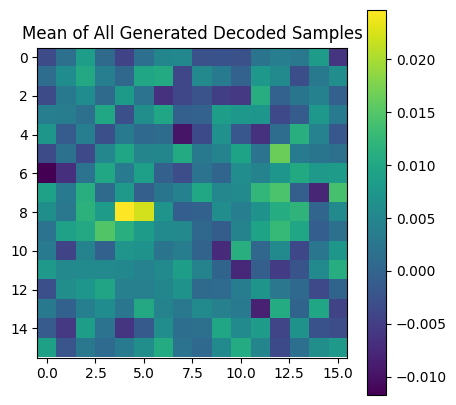

[[1.00347459 0.99823403 0.9913221  0.99910879 1.00421584 0.99844468
  0.9949677  0.99478972 1.00274277 1.00255394 1.00275898 0.99778831
  0.99609983 0.99718946 0.99156821 1.00613463]
 [0.9986493  0.99405122 0.98980546 0.99614084 0.99939197 0.99037069
  0.9894681  1.00392199 0.99466819 0.99651068 1.00026405 0.99235022
  0.99424356 1.00299096 0.99704409 0.99390721]
 [1.00344825 0.99697429 0.99389189 0.9991926  0.99201912 0.99786901
  1.00656486 1.00398302 1.00245416 1.00496936 1.00576794 0.98901331
  1.00027001 0.99760658 0.995736   1.00059307]
 [0.99618173 0.99625856 0.9982627  0.99001986 1.00294054 0.99366146
  0.99021989 1.0006398  1.00024164 0.99150914 0.99229735 0.99256057
  1.00373018 1.00110126 0.9922837  0.9967643 ]
 [0.99246603 1.00115907 0.99614775 1.0028441  0.99667609 0.99930149
  0.99882722 1.0096972  1.00363517 0.99333894 1.0017854  1.00655746
  0.99873185 0.98867714 0.99566048 1.00184178]
 [1.00326943 0.99819827 1.00370038 0.99481708 0.9901619  0.99518937
  0.9950335  0.98

In [22]:
num_samples_to_generate = 100
new_images = generate_new_images(model, num_samples_to_generate)
plot_mean_decoded_images(flip(new_images))
plot_all_decoded_images(flip(new_images), grid_size=(10, 10))

In [19]:
generated_data = new_images

real_data = data_X[:len(generated_data)]

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(flip(generated_data))
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

wasserstein_value = calculate_wasserstein(real_data, flip(generated_data))
print("Wasserstein 1 ", wasserstein_value)

FID  1.0146386098434836
Wasserstein 1  0.008944120544474571


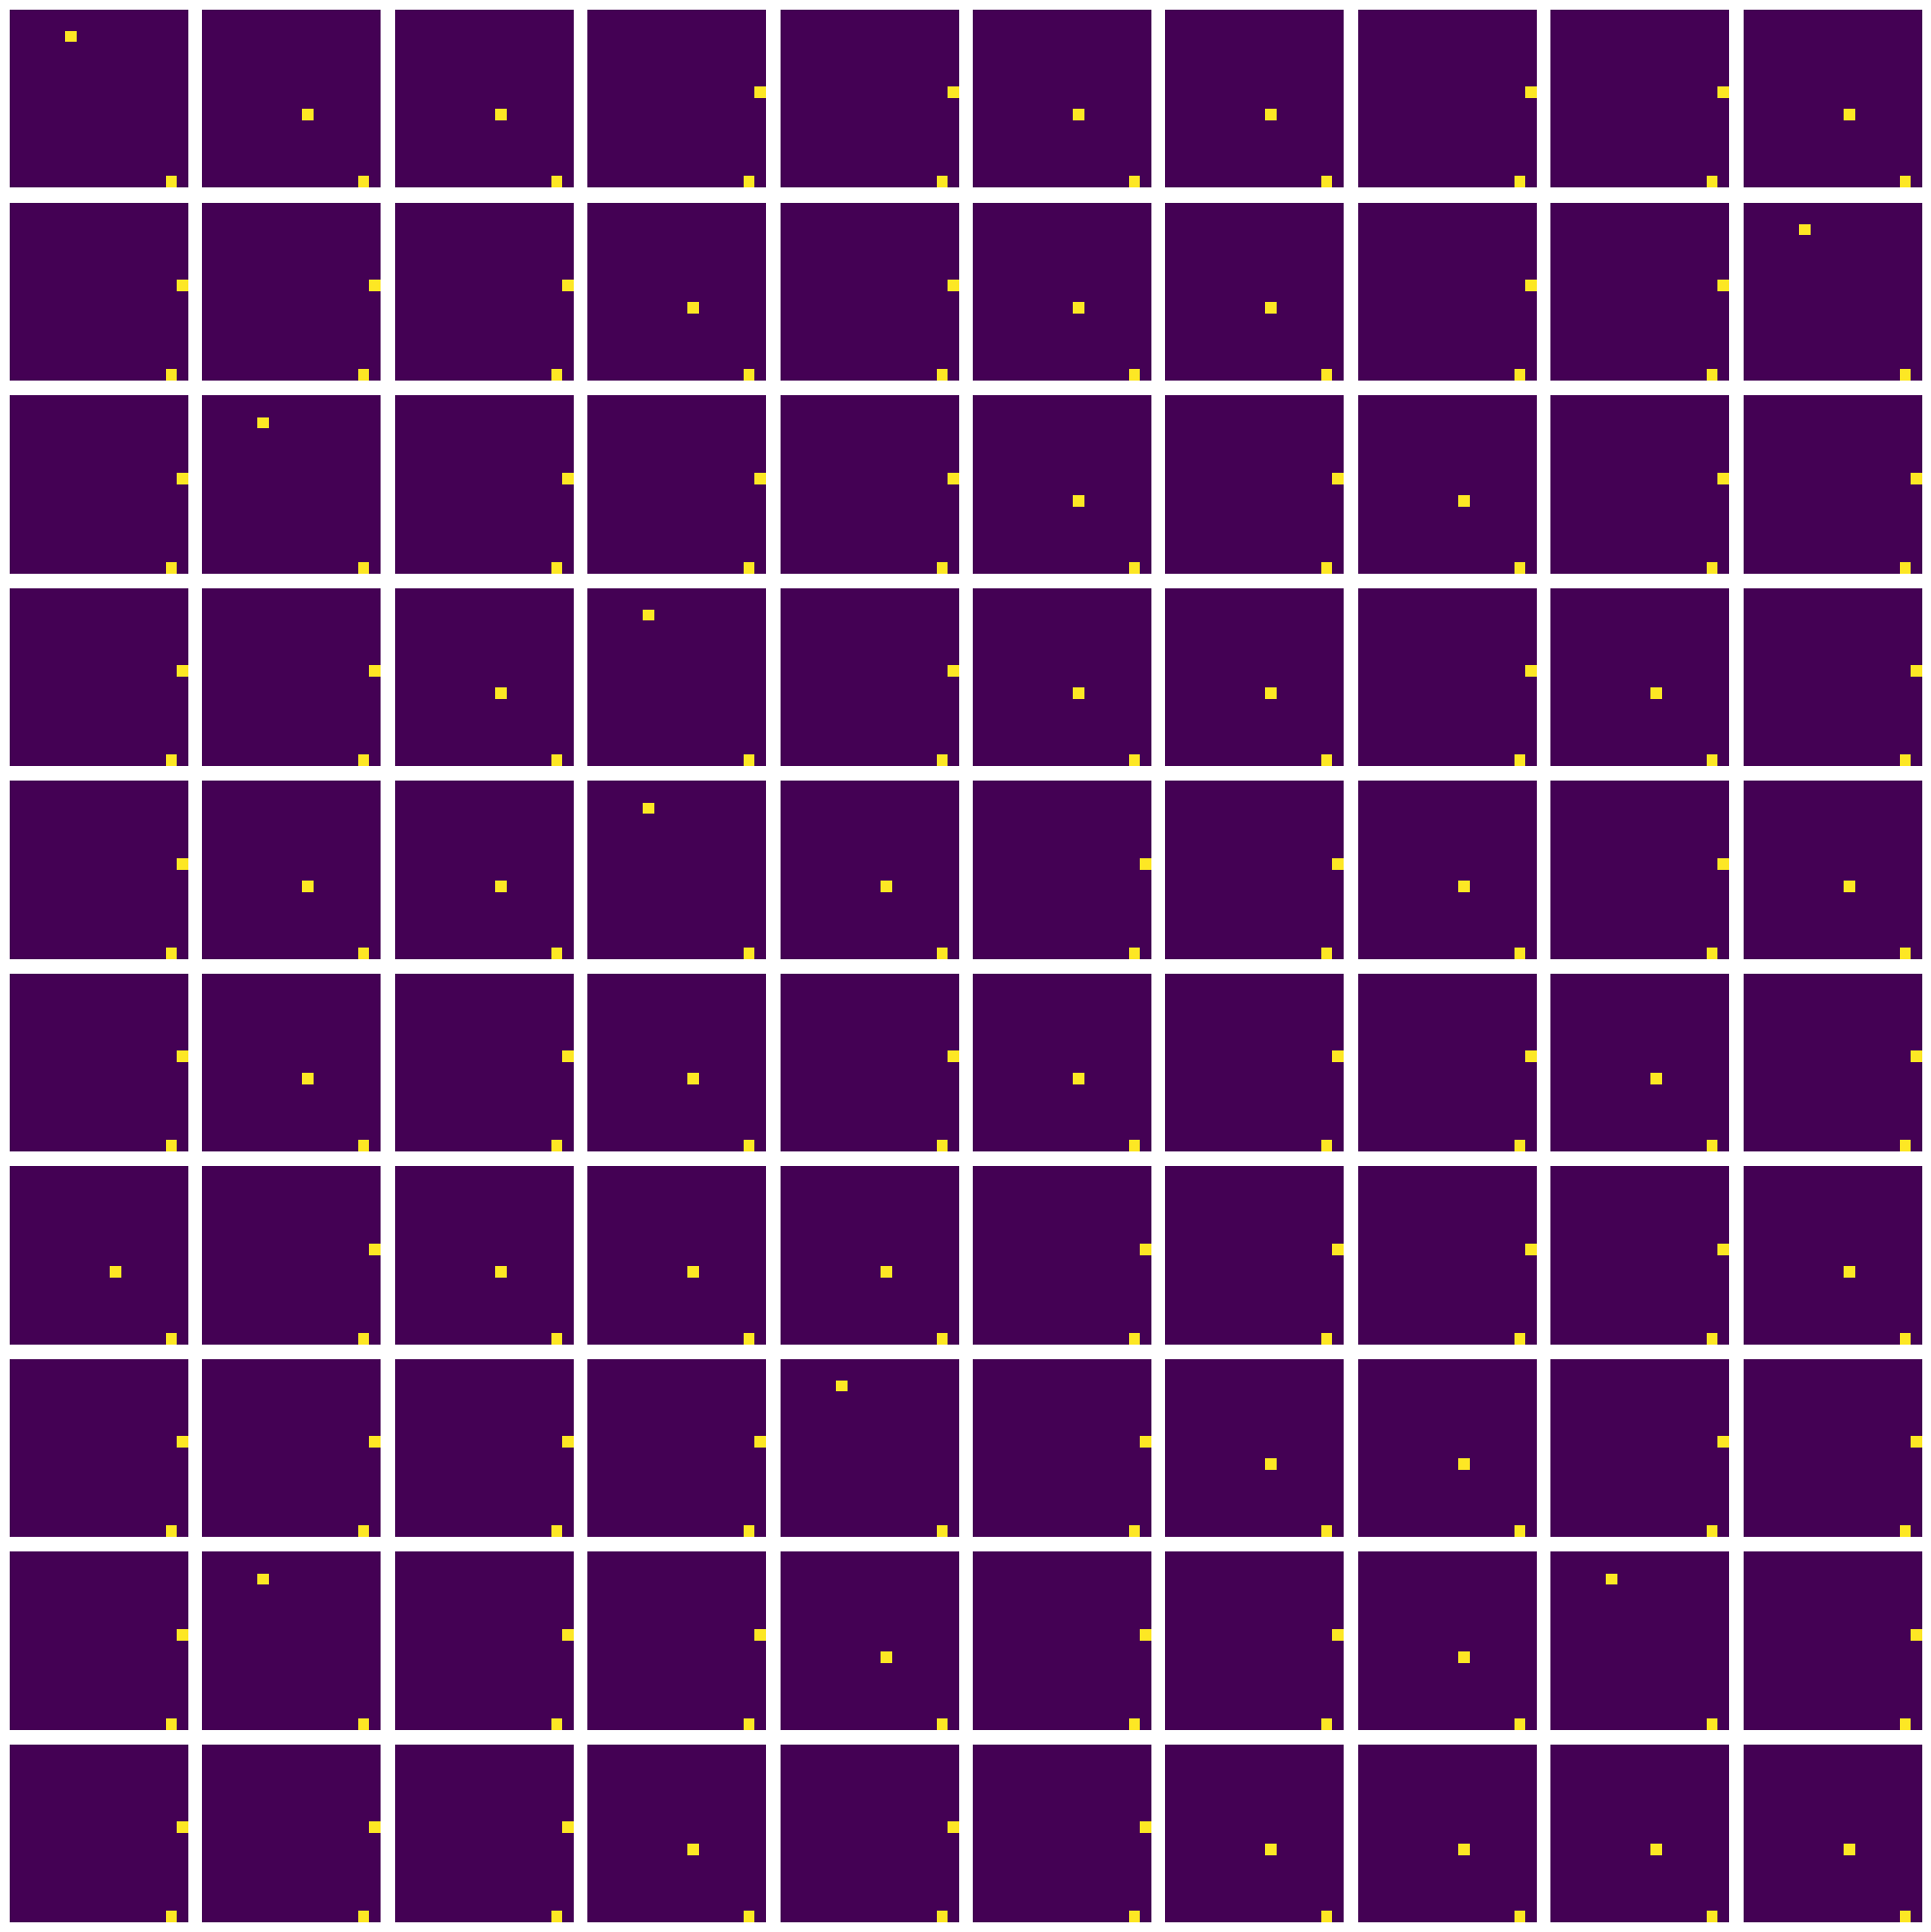

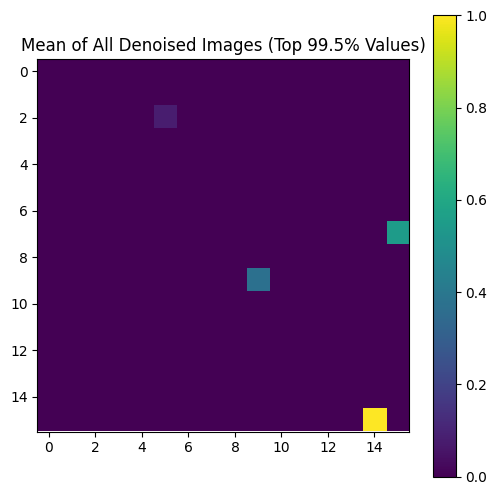

FID  3.170406908810591
Stable FID: 3.1623988864310864
Wasserstein 1  0.003921751212328672


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\scipy\linalg\_matfuncs_sqrtm.py:209: RuntimeWarning: invalid value encountered in scalar divide
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


In [7]:
denoised_images = plot_decoded_images_without_noise(new_images, grid_size=(10, 10), threshold_percent=99.5)

limit = 10
real_data = real_data[:limit]
denoised_images = denoised_images[:limit]
mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid_stable(mu_real, sigma_real, mu_gen, sigma_gen)
print("Stable FID:", fid)

wasserstein_value = calculate_wasserstein(real_data, denoised_images)
print("Wasserstein 1 ", wasserstein_value)